In [1]:
#inspired by:
#https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/
import torch
import torchvision

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(download=True, root='./data', train=True, transform=transform)
testset  = torchvision.datasets.MNIST(download=True, root='./data', train=False, transform=transform)

In [10]:
BATCH_SIZE = 128
LOG_INTERVAL = 10

In [11]:
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE, num_workers=2)

In [20]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #encoder
        self.fc1  = torch.nn.Linear(784, 400)
        self.relu = torch.nn.ReLU()
        self.fc21 = torch.nn.Linear(400, 20)
        self.fc22 = torch.nn.Linear(400, 20)
        #decoder
        self.fc3 = torch.nn.Linear(20, 400)
        self.fc4 = torch.nn.Linear(400, 784)
        self.sigmoid = torch.nn.Sigmoid()
    def encode(self, x):
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)
    
    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))
    
    def reparameterize(self, mu, logvar): 
        std = logvar.mul(0.5).exp_() 
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = Autoencoder()

In [24]:
def loss_function(recon_x, x, mu, logvar):
    # how well do input x and output recon_x agree?
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

In [25]:
#criterion = torch.nn.functional.binary_cross_entropy()
#criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adadelta(autoencoder.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
###
import timeit
start_time = timeit.default_timer()
###
train_loss = 0
for epoch in range(1):
    for batch_number, (data, _) in enumerate(trainset):
        optimizer.zero_grad()
        data = torch.autograd.Variable(data, requires_grad=False)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_number % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_number * len(data), len(trainloader.dataset),
                100. * batch_number / len(trainloader),
                loss.data[0] / len(data)))


        '''
        x, _ = data
        x = x.view(1, 784)
        x = torch.autograd.Variable(x)
        output = autoencoder(x)
        #output = output.view(1, 784)
        loss = criterion(output, x)
        #loss = torch.nn.functional.binary_cross_entropy(output, x)
        loss.backward()
        optimizer.step()
        if batch_number % 2000 == 1999:
            print('epoch: ', epoch, 'loss: ', loss.data[0])
        '''
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))
###
elapsed = timeit.default_timer() - start_time
print("time: ", elapsed)
###

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.620886
====> Epoch: 0 Average loss: 0.0000
====> Epoch: 0 Average loss: 0.0000
====> Epoch: 0 Average loss: 0.0000
====> Epoch: 0 Average loss: 0.0000
====> Epoch: 0 Average loss: 0.0000
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
Train Epoch: 0 [10/60000 (2%)]	Loss: 0.416756
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
====> Epoch: 0 Average loss: 0.0001
Train Epoch: 0 [20/60000 (4%)]	Loss: 0.585919
====> Epoch: 0 Average loss: 0.0002
====> Epoch: 0 Average loss: 0.0002
====> Epoch: 0 Average loss: 0.0002
====> Epoch: 0 Average loss: 0.0002

====> Epoch: 0 Average loss: 0.0010
Train Epoch: 0 [210/60000 (45%)]	Loss: 0.260426
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
Train Epoch: 0 [220/60000 (47%)]	Loss: 0.375292
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0010
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss: 0.0011
Train Epoch: 0 [230/60000 (49%)]	Loss: 0.177731
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss: 0.0011
====> Epoch: 0 Average loss:

====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0017
Train Epoch: 0 [420/60000 (90%)]	Loss: 0.143160
====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0017
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
Train Epoch: 0 [430/60000 (92%)]	Loss: 0.220212
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
====> Epoch: 0 Average loss: 0.0018
Train Epoch: 0 [440/60000 (94%)]	Loss: 0

====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
Train Epoch: 0 [630/60000 (134%)]	Loss: 0.155698
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
Train Epoch: 0 [640/60000 (136%)]	Loss: 0.243883
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0024
====> Epoch: 0 Average loss: 0.0025
====> Epoch: 0 Average loss: 0.0025
====> Epoch: 0 Average loss: 0.0025
====> Epoch: 0 Average loss: 0.0025
====> Epoch: 0 Average loss: 0.0025
====> Epoch: 0 Average loss: 0.0025
====> Epoch: 0 Average loss: 0.0025
Train Epoch: 0 [650/60000 (139%)]	Loss: 0.216158
====> Epoch: 0 Average loss: 0.0025
====> Epoch: 0 Average lo

====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
Train Epoch: 0 [840/60000 (179%)]	Loss: 0.210352
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0030
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
Train Epoch: 0 [850/60000 (181%)]	Loss: 0.201070
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
====> Epoch: 0 Average loss: 0.0031
==

====> Epoch: 0 Average loss: 0.0036
====> Epoch: 0 Average loss: 0.0036
====> Epoch: 0 Average loss: 0.0036
====> Epoch: 0 Average loss: 0.0036
====> Epoch: 0 Average loss: 0.0037
Train Epoch: 0 [1050/60000 (224%)]	Loss: 0.212415
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
Train Epoch: 0 [1060/60000 (226%)]	Loss: 0.076827
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037
====> Epoch: 0 Average loss: 0.0037


====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0042
Train Epoch: 0 [1260/60000 (269%)]	Loss: 0.289554
====> Epoch: 0 Average loss: 0.0042
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
Train Epoch: 0 [1270/60000 (271%)]	Loss: 0.125606
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043
====> Epoch: 0 Average loss: 0.0043


====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
Train Epoch: 0 [1460/60000 (311%)]	Loss: 0.225780
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
Train Epoch: 0 [1470/60000 (313%)]	Loss: 0.168017
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0048
====> Epoch: 0 Average loss: 0.0049
====> Epoch: 0 Average loss: 0.0049
====> Epoch: 0 Average loss: 0.0049
====> Epoch: 0 Average loss: 0.0049
Train Epoch: 0 [1480/60000 (316%)]	L

====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
Train Epoch: 0 [1670/60000 (356%)]	Loss: 0.186347
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
Train Epoch: 0 [1680/60000 (358%)]	Loss: 0.049606
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average loss: 0.0054
Train Epoch: 0 [1690/60000 (360%)]	Loss: 0.216432
====> Epoch: 0 Average loss: 0.0054
====> Epoch: 0 Average

====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
Train Epoch: 0 [1880/60000 (401%)]	Loss: 0.212433
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
Train Epoch: 0 [1890/60000 (403%)]	Loss: 0.137571
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0059
====> Epoch: 0 Average loss: 0.0060
====> Epoch: 0 Average loss: 0.0060
Train Epoch: 0 [1900/60000 (405%)]	Loss: 0.189062
====> Epoch: 0 Average

====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
Train Epoch: 0 [2090/60000 (446%)]	Loss: 0.105433
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0064
====> Epoch: 0 Average loss: 0.0065
Train Epoch: 0 [2100/60000 (448%)]	Loss: 0.175765
====> Epoch: 0 Average loss: 0.0065
====> Epoch: 0 Average loss: 0.0065
====> Epoch: 0 Average loss: 0.0065
====> Epoch: 0 Average loss: 0.0065
====> Epoch: 0 Average loss: 0.0065
====> Epoch: 0 Average loss: 0.0065
====> Epoch: 0 Average loss: 0.0065


====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
Train Epoch: 0 [2290/60000 (488%)]	Loss: 0.215507
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
====> Epoch: 0 Average loss: 0.0069
Train Epoch: 0 [2300/60000 (490%)]	Loss: 0.136854
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average loss: 0.0070
Train Epoch: 0 [2310/60000 (493%)]	Loss: 0.190295
====> Epoch: 0 Average loss: 0.0070
====> Epoch: 0 Average

====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
Train Epoch: 0 [2500/60000 (533%)]	Loss: 0.162850
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0074
Train Epoch: 0 [2510/60000 (535%)]	Loss: 0.183230
====> Epoch: 0 Average loss: 0.0074
====> Epoch: 0 Average loss: 0.0075
====> Epoch: 0 Average loss: 0.0075
====> Epoch: 0 Average loss: 0.0075
====> Epoch: 0 Average loss: 0.0075
====> Epoch: 0 Average loss: 0.0075
====> Epoch: 0 Average loss: 0.0075
====> Epoch: 0 Average loss: 0.0075
====> Epoch: 0 Average loss: 0.0075
====> Epoch: 0 Average loss: 0.0075
Train Epoch: 0 [2520/60000 (537%)]	Loss: 0.177899
====> Epoch: 0 Average

====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
Train Epoch: 0 [2700/60000 (576%)]	Loss: 0.190335
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
Train Epoch: 0 [2710/60000 (578%)]	Loss: 0.128714
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average loss: 0.0079
Train Epoch: 0 [2720/60000 (580%)]	Loss: 0.098087
====> Epoch: 0 Average loss: 0.0079
====> Epoch: 0 Average

====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
Train Epoch: 0 [2910/60000 (620%)]	Loss: 0.103490
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
Train Epoch: 0 [2920/60000 (623%)]	Loss: 0.059553
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0084
====> Epoch: 0 Average loss: 0.0085
====> Epoch: 0 Average loss: 0.0085


Train Epoch: 0 [3110/60000 (663%)]	Loss: 0.143693
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
Train Epoch: 0 [3120/60000 (665%)]	Loss: 0.063229
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
Train Epoch: 0 [3130/60000 (667%)]	Loss: 0.060325
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average loss: 0.0089
====> Epoch: 0 Average

====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
Train Epoch: 0 [3320/60000 (708%)]	Loss: 0.115698
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
Train Epoch: 0 [3330/60000 (710%)]	Loss: 0.181779
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0093
====> Epoch: 0 Average loss: 0.0094
====> Epoch: 0 Average loss: 0.0094
====> Epoch: 0 Average loss: 0.0094
====> Epoch: 0 Average loss: 0.0094
====> Epoch: 0 Average loss: 0.0094
====> Epoch: 0 Average loss: 0.0094


====> Epoch: 0 Average loss: 0.0097
====> Epoch: 0 Average loss: 0.0097
====> Epoch: 0 Average loss: 0.0097
====> Epoch: 0 Average loss: 0.0097
====> Epoch: 0 Average loss: 0.0098
Train Epoch: 0 [3520/60000 (751%)]	Loss: 0.112644
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
Train Epoch: 0 [3530/60000 (753%)]	Loss: 0.125034
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098
====> Epoch: 0 Average loss: 0.0098


====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
Train Epoch: 0 [3730/60000 (795%)]	Loss: 0.232858
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
Train Epoch: 0 [3740/60000 (797%)]	Loss: 0.165558
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103
====> Epoch: 0 Average loss: 0.0103


====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
Train Epoch: 0 [3940/60000 (840%)]	Loss: 0.110441
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0107
====> Epoch: 0 Average loss: 0.0108
Train Epoch: 0 [3950/60000 (842%)]	Loss: 0.192101
====> Epoch: 0 Average loss: 0.0108
====> Epoch: 0 Average loss: 0.0108
====> Epoch: 0 Average loss: 0.0108
====> Epoch: 0 Average loss: 0.0108
====> Epoch: 0 Average loss: 0.0108
====> Epoch: 0 Average loss: 0.0108
====> Epoch: 0 Average loss: 0.0108


====> Epoch: 0 Average loss: 0.0111
====> Epoch: 0 Average loss: 0.0111
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
Train Epoch: 0 [4140/60000 (883%)]	Loss: 0.049279
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
Train Epoch: 0 [4150/60000 (885%)]	Loss: 0.140283
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112
====> Epoch: 0 Average loss: 0.0112


====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
Train Epoch: 0 [4350/60000 (928%)]	Loss: 0.097097
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
Train Epoch: 0 [4360/60000 (930%)]	Loss: 0.321206
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116
====> Epoch: 0 Average loss: 0.0116


====> Epoch: 0 Average loss: 0.0120
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
Train Epoch: 0 [4560/60000 (972%)]	Loss: 0.113498
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
Train Epoch: 0 [4570/60000 (974%)]	Loss: 0.150703
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121
====> Epoch: 0 Average loss: 0.0121


Train Epoch: 0 [4760/60000 (1015%)]	Loss: 0.166625
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
Train Epoch: 0 [4770/60000 (1017%)]	Loss: 0.116669
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
Train Epoch: 0 [4780/60000 (1019%)]	Loss: 0.093994
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Average loss: 0.0125
====> Epoch: 0 Aver

Train Epoch: 0 [4960/60000 (1058%)]	Loss: 0.041303
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
Train Epoch: 0 [4970/60000 (1060%)]	Loss: 0.067820
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
Train Epoch: 0 [4980/60000 (1062%)]	Loss: 0.098501
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Average loss: 0.0130
====> Epoch: 0 Aver

Train Epoch: 0 [5170/60000 (1102%)]	Loss: 0.180976
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
Train Epoch: 0 [5180/60000 (1104%)]	Loss: 0.089542
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
Train Epoch: 0 [5190/60000 (1107%)]	Loss: 0.099373
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Average loss: 0.0134
====> Epoch: 0 Aver

Train Epoch: 0 [5370/60000 (1145%)]	Loss: 0.151691
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
Train Epoch: 0 [5380/60000 (1147%)]	Loss: 0.141029
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0138
====> Epoch: 0 Average loss: 0.0139
====> Epoch: 0 Average loss: 0.0139
====> Epoch: 0 Average loss: 0.0139
====> Epoch: 0 Average loss: 0.0139
Train Epoch: 0 [5390/60000 (1149%)]	Loss: 0.090059
====> Epoch: 0 Average loss: 0.0139
====> Epoch: 0 Average loss: 0.0139
====> Epoch: 0 Average loss: 0.0139
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0142
====> Epoch: 0 Average loss: 0.0142
Train Epoch: 0 [5580/60000 (1190%)]	Loss: 0.191724
====> Epoch: 0 Average loss: 0.0142
====> Epoch: 0 Average loss: 0.0142
====> Epoch: 0 Average loss: 0.0142
====> Epoch: 0 Average loss: 0.0142
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
Train Epoch: 0 [5590/60000 (1192%)]	Loss: 0.109791
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Average loss: 0.0143
Train Epoch: 0 [5600/60000 (1194%)]	Loss: 0.126646
====> Epoch: 0 Average loss: 0.0143
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0146
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
Train Epoch: 0 [5790/60000 (1235%)]	Loss: 0.182291
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
Train Epoch: 0 [5800/60000 (1237%)]	Loss: 0.185611
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.0147
====> Epoch: 0 Average loss: 0.014

Train Epoch: 0 [5990/60000 (1277%)]	Loss: 0.135798
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
Train Epoch: 0 [6000/60000 (1279%)]	Loss: 0.100922
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
Train Epoch: 0 [6010/60000 (1281%)]	Loss: 0.079450
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Average loss: 0.0151
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
Train Epoch: 0 [6200/60000 (1322%)]	Loss: 0.148055
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
Train Epoch: 0 [6210/60000 (1324%)]	Loss: 0.120611
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
====> Epoch: 0 Average loss: 0.0155
Train Epoch: 0 [6220/60000 (1326%)]	Loss: 0.113310
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
Train Epoch: 0 [6410/60000 (1367%)]	Loss: 0.104419
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
Train Epoch: 0 [6420/60000 (1369%)]	Loss: 0.157573
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Average loss: 0.0159
Train Epoch: 0 [6430/60000 (1371%)]	Loss: 0.175612
====> Epoch: 0 Average loss: 0.0159
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0163
Train Epoch: 0 [6610/60000 (1409%)]	Loss: 0.189776
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
Train Epoch: 0 [6620/60000 (1412%)]	Loss: 0.135800
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
Train Epoch: 0 [6630/60000 (1414%)]	Loss: 0.105903
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Average loss: 0.0163
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0166
====> Epoch: 0 Average loss: 0.0166
====> Epoch: 0 Average loss: 0.0166
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
Train Epoch: 0 [6820/60000 (1454%)]	Loss: 0.097734
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
Train Epoch: 0 [6830/60000 (1456%)]	Loss: 0.202297
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.0167
====> Epoch: 0 Average loss: 0.016

====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
Train Epoch: 0 [7020/60000 (1497%)]	Loss: 0.040283
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
Train Epoch: 0 [7030/60000 (1499%)]	Loss: 0.105845
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.0171
====> Epoch: 0 Average loss: 0.017

====> Epoch: 0 Average loss: 0.0174
====> Epoch: 0 Average loss: 0.0174
====> Epoch: 0 Average loss: 0.0174
Train Epoch: 0 [7220/60000 (1539%)]	Loss: 0.113402
====> Epoch: 0 Average loss: 0.0174
====> Epoch: 0 Average loss: 0.0174
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
Train Epoch: 0 [7230/60000 (1542%)]	Loss: 0.126462
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
====> Epoch: 0 Average loss: 0.0175
Train Epoch: 0 [7240/60000 (1544%)]	Loss: 0.053086
====> Epoch: 0 Aver

Train Epoch: 0 [7420/60000 (1582%)]	Loss: 0.080174
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
Train Epoch: 0 [7430/60000 (1584%)]	Loss: 0.144646
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
Train Epoch: 0 [7440/60000 (1586%)]	Loss: 0.065364
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Average loss: 0.0179
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
Train Epoch: 0 [7630/60000 (1627%)]	Loss: 0.058977
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0182
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
Train Epoch: 0 [7640/60000 (1629%)]	Loss: 0.137771
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
====> Epoch: 0 Average loss: 0.0183
Train Epoch: 0 [7650/60000 (1631%)

====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
Train Epoch: 0 [7840/60000 (1672%)]	Loss: 0.127404
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
Train Epoch: 0 [7850/60000 (1674%)]	Loss: 0.063254
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
====> Epoch: 0 Average loss: 0.0187
Train Epoch: 0 [7860/60000 (1676%)

====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
Train Epoch: 0 [8040/60000 (1714%)]	Loss: 0.053052
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
Train Epoch: 0 [8050/60000 (1716%)]	Loss: 0.187793
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Average loss: 0.0191
Train Epoch: 0 [8060/60000 (1719%)]	Loss: 0.126686
====> Epoch: 0 Average loss: 0.0191
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0194
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
Train Epoch: 0 [8250/60000 (1759%)]	Loss: 0.103643
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
Train Epoch: 0 [8260/60000 (1761%)]	Loss: 0.112227
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.0195
====> Epoch: 0 Average loss: 0.019

====> Epoch: 0 Average loss: 0.0198
====> Epoch: 0 Average loss: 0.0198
====> Epoch: 0 Average loss: 0.0198
====> Epoch: 0 Average loss: 0.0198
Train Epoch: 0 [8450/60000 (1802%)]	Loss: 0.074527
====> Epoch: 0 Average loss: 0.0198
====> Epoch: 0 Average loss: 0.0198
====> Epoch: 0 Average loss: 0.0198
====> Epoch: 0 Average loss: 0.0198
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
Train Epoch: 0 [8460/60000 (1804%)]	Loss: 0.150422
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
====> Epoch: 0 Average loss: 0.0199
Train Epoch: 0 [8470/60000 (1806%)

====> Epoch: 0 Average loss: 0.0202
====> Epoch: 0 Average loss: 0.0202
====> Epoch: 0 Average loss: 0.0202
====> Epoch: 0 Average loss: 0.0202
====> Epoch: 0 Average loss: 0.0202
Train Epoch: 0 [8660/60000 (1846%)]	Loss: 0.053324
====> Epoch: 0 Average loss: 0.0202
====> Epoch: 0 Average loss: 0.0202
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
Train Epoch: 0 [8670/60000 (1849%)]	Loss: 0.125839
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.0203
====> Epoch: 0 Average loss: 0.020

====> Epoch: 0 Average loss: 0.0206
====> Epoch: 0 Average loss: 0.0206
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
Train Epoch: 0 [8870/60000 (1891%)]	Loss: 0.116263
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
Train Epoch: 0 [8880/60000 (1893%)]	Loss: 0.106176
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.0207
====> Epoch: 0 Average loss: 0.020

====> Epoch: 0 Average loss: 0.0210
====> Epoch: 0 Average loss: 0.0210
====> Epoch: 0 Average loss: 0.0210
====> Epoch: 0 Average loss: 0.0210
====> Epoch: 0 Average loss: 0.0210
Train Epoch: 0 [9080/60000 (1936%)]	Loss: 0.109133
====> Epoch: 0 Average loss: 0.0210
====> Epoch: 0 Average loss: 0.0210
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
Train Epoch: 0 [9090/60000 (1938%)]	Loss: 0.168257
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.0211
====> Epoch: 0 Average loss: 0.021

====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0214
Train Epoch: 0 [9290/60000 (1981%)]	Loss: 0.139411
====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0214
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
Train Epoch: 0 [9300/60000 (1983%)]	Loss: 0.115365
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.0215
====> Epoch: 0 Average loss: 0.021

====> Epoch: 0 Average loss: 0.0219
Train Epoch: 0 [9490/60000 (2023%)]	Loss: 0.185994
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
Train Epoch: 0 [9500/60000 (2026%)]	Loss: 0.085122
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
Train Epoch: 0 [9510/60000 (2028%)]	Loss: 0.118450
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Average loss: 0.0219
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
Train Epoch: 0 [9700/60000 (2068%)]	Loss: 0.110982
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
Train Epoch: 0 [9710/60000 (2070%)]	Loss: 0.136665
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
====> Epoch: 0 Average loss: 0.0223
Train Epoch: 0 [9720/60000 (2072%)]	Loss: 0.121158
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
Train Epoch: 0 [9910/60000 (2113%)]	Loss: 0.032654
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
Train Epoch: 0 [9920/60000 (2115%)]	Loss: 0.104338
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
====> Epoch: 0 Average loss: 0.0227
Train Epoch: 0 [9930/60000 (2117%)]	Loss: 0.042356
====> Epoch: 0 Aver

====> Epoch: 0 Average loss: 0.0230
====> Epoch: 0 Average loss: 0.0230
====> Epoch: 0 Average loss: 0.0230
====> Epoch: 0 Average loss: 0.0230
Train Epoch: 0 [10110/60000 (2156%)]	Loss: 0.047097
====> Epoch: 0 Average loss: 0.0230
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
Train Epoch: 0 [10120/60000 (2158%)]	Loss: 0.125637
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
====> Epoch: 0 Average loss: 0.0231
Train Epoch: 0 [10130/60000 (216

====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
Train Epoch: 0 [10320/60000 (2200%)]	Loss: 0.130640
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0234
====> Epoch: 0 Average loss: 0.0235
Train Epoch: 0 [10330/60000 (2203%)]	Loss: 0.111290
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0235
====> Epoch: 0 Average loss: 0.0

Train Epoch: 0 [10520/60000 (2243%)]	Loss: 0.189152
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
Train Epoch: 0 [10530/60000 (2245%)]	Loss: 0.134590
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0238
====> Epoch: 0 Average loss: 0.0239
Train Epoch: 0 [10540/60000 (2247%)]	Loss: 0.093890
====> Epoch: 0 Average loss: 0.0239
====> Epoch: 0 Average loss: 0.0239
====> Epoch: 0 Average loss: 0.0239
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
Train Epoch: 0 [10730/60000 (2288%)]	Loss: 0.140786
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
Train Epoch: 0 [10740/60000 (2290%)]	Loss: 0.121504
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0242
====> Epoch: 0 Average loss: 0.0

Train Epoch: 0 [10930/60000 (2330%)]	Loss: 0.127520
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
Train Epoch: 0 [10940/60000 (2333%)]	Loss: 0.075206
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
Train Epoch: 0 [10950/60000 (2335%)]	Loss: 0.114139
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 Average loss: 0.0246
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
Train Epoch: 0 [11140/60000 (2375%)]	Loss: 0.079801
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
====> Epoch: 0 Average loss: 0.0249
Train Epoch: 0 [11150/60000 (2377%)]	Loss: 0.086740
====> Epoch: 0 Average loss: 0.0250
====> Epoch: 0 Average loss: 0.0250
====> Epoch: 0 Average loss: 0.0250
====> Epoch: 0 Average loss: 0.0250
====> Epoch: 0 Average loss: 0.0250
====> Epoch: 0 Average loss: 0.0250
====> Epoch: 0 Average loss: 0.0250
====> Epoch: 0 Average loss: 0.0250
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
Train Epoch: 0 [11340/60000 (2418%)]	Loss: 0.098155
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
Train Epoch: 0 [11350/60000 (2420%)]	Loss: 0.082229
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 Average loss: 0.0253
Train Epoch: 0 [11360/60000 (2422%)]	Loss: 0.047420
====> Epoch: 0 Average loss: 0.0253
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0256
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
Train Epoch: 0 [11550/60000 (2463%)]	Loss: 0.068837
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
Train Epoch: 0 [11560/60000 (2465%)]	Loss: 0.141305
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0257
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0260
Train Epoch: 0 [11750/60000 (2505%)]	Loss: 0.141847
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
Train Epoch: 0 [11760/60000 (2507%)]	Loss: 0.042452
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
====> Epoch: 0 Average loss: 0.0260
Train Epoch: 0 [11770/60000 (2510%)]	Loss: 0.087896
====> Epoch: 0 Average loss: 0.0261
====> Epoch: 0 Average loss: 0.0261
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
Train Epoch: 0 [11960/60000 (2550%)]	Loss: 0.195637
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
Train Epoch: 0 [11970/60000 (2552%)]	Loss: 0.116126
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
====> Epoch: 0 Average loss: 0.0264
Train Epoch: 0 [11980/60000 (255

Train Epoch: 0 [12160/60000 (2593%)]	Loss: 0.106624
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0267
Train Epoch: 0 [12170/60000 (2595%)]	Loss: 0.105988
====> Epoch: 0 Average loss: 0.0267
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
Train Epoch: 0 [12180/60000 (2597%)]	Loss: 0.142103
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 Average loss: 0.0268
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
Train Epoch: 0 [12370/60000 (2638%)]	Loss: 0.147573
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
====> Epoch: 0 Average loss: 0.0271
Train Epoch: 0 [12380/60000 (2640%)]	Loss: 0.074931
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0272
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
Train Epoch: 0 [12570/60000 (2680%)]	Loss: 0.091617
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
Train Epoch: 0 [12580/60000 (2682%)]	Loss: 0.134422
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0275
====> Epoch: 0 Average loss: 0.0276
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
Train Epoch: 0 [12770/60000 (2723%)]	Loss: 0.087838
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
Train Epoch: 0 [12780/60000 (2725%)]	Loss: 0.101757
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 Average loss: 0.0279
Train Epoch: 0 [12790/60000 (2727%)]	Loss: 0.092891
====> Epoch: 0 Average loss: 0.0279
====> Epoch: 0 A

Train Epoch: 0 [12970/60000 (2765%)]	Loss: 0.082878
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
Train Epoch: 0 [12980/60000 (2768%)]	Loss: 0.149723
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
Train Epoch: 0 [12990/60000 (2770%)]	Loss: 0.091912
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 Average loss: 0.0283
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
Train Epoch: 0 [13180/60000 (2810%)]	Loss: 0.065607
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
Train Epoch: 0 [13190/60000 (2812%)]	Loss: 0.151337
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0287
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
Train Epoch: 0 [13380/60000 (2853%)]	Loss: 0.098904
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
Train Epoch: 0 [13390/60000 (2855%)]	Loss: 0.050224
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
====> Epoch: 0 Average loss: 0.0291
Train Epoch: 0 [13400/60000 (2857%)]	Loss: 0.180974
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
Train Epoch: 0 [13580/60000 (2896%)]	Loss: 0.139143
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
Train Epoch: 0 [13590/60000 (2898%)]	Loss: 0.064736
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0294
====> Epoch: 0 Average loss: 0.0295
====> Epoch: 0 Average loss: 0.0295
====> Epoch: 0 Average loss: 0.0295
====> Epoch: 0 Average loss: 0.0295
====> Epoch: 0 Average loss: 0.0295
====> Epoch: 0 Average loss: 0.0295
====> Epoch: 0 Average loss: 0.0295
Train Epoch: 0 [13600/60000 (2900%)]	Loss: 0.094034
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
Train Epoch: 0 [13790/60000 (2940%)]	Loss: 0.039653
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
Train Epoch: 0 [13800/60000 (2942%)]	Loss: 0.149152
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0298
====> Epoch: 0 Average loss: 0.0

Train Epoch: 0 [13990/60000 (2983%)]	Loss: 0.108727
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
Train Epoch: 0 [14000/60000 (2985%)]	Loss: 0.035084
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
Train Epoch: 0 [14010/60000 (2987%)]	Loss: 0.131394
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 Average loss: 0.0302
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
Train Epoch: 0 [14200/60000 (3028%)]	Loss: 0.121139
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
Train Epoch: 0 [14210/60000 (3030%)]	Loss: 0.189540
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
====> Epoch: 0 Average loss: 0.0306
Train Epoch: 0 [14220/60000 (303

Train Epoch: 0 [14400/60000 (3070%)]	Loss: 0.118334
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
Train Epoch: 0 [14410/60000 (3072%)]	Loss: 0.103177
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
Train Epoch: 0 [14420/60000 (3075%)]	Loss: 0.119605
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 Average loss: 0.0310
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
Train Epoch: 0 [14610/60000 (3115%)]	Loss: 0.112404
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0313
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
Train Epoch: 0 [14620/60000 (3117%)]	Loss: 0.088975
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0314
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
Train Epoch: 0 [14810/60000 (3158%)]	Loss: 0.109514
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0317
====> Epoch: 0 Average loss: 0.0318
Train Epoch: 0 [14820/60000 (3160%)]	Loss: 0.118468
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 Average loss: 0.0318
Train Epoch: 0 [14830/60000 (3162%)]	Loss: 0.206646
====> Epoch: 0 Average loss: 0.0318
====> Epoch: 0 A

Train Epoch: 0 [15010/60000 (3200%)]	Loss: 0.087332
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
Train Epoch: 0 [15020/60000 (3203%)]	Loss: 0.038791
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
Train Epoch: 0 [15030/60000 (3205%)]	Loss: 0.161300
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 Average loss: 0.0321
====> Epoch: 0 A

Train Epoch: 0 [15210/60000 (3243%)]	Loss: 0.115608
====> Epoch: 0 Average loss: 0.0324
====> Epoch: 0 Average loss: 0.0324
====> Epoch: 0 Average loss: 0.0324
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
Train Epoch: 0 [15220/60000 (3245%)]	Loss: 0.083434
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
Train Epoch: 0 [15230/60000 (3247%)]	Loss: 0.059921
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 Average loss: 0.0325
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
Train Epoch: 0 [15420/60000 (3288%)]	Loss: 0.093087
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
Train Epoch: 0 [15430/60000 (3290%)]	Loss: 0.123235
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0328
====> Epoch: 0 Average loss: 0.0329
====> Epoch: 0 Average loss: 0.0329
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
Train Epoch: 0 [15620/60000 (3330%)]	Loss: 0.077402
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
Train Epoch: 0 [15630/60000 (3333%)]	Loss: 0.169678
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0332
====> Epoch: 0 Average loss: 0.0

Train Epoch: 0 [15820/60000 (3373%)]	Loss: 0.117965
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
Train Epoch: 0 [15830/60000 (3375%)]	Loss: 0.139918
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
Train Epoch: 0 [15840/60000 (3377%)]	Loss: 0.074677
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 Average loss: 0.0336
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
Train Epoch: 0 [16030/60000 (3418%)]	Loss: 0.173572
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0339
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
Train Epoch: 0 [16040/60000 (3420%)]	Loss: 0.122804
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
====> Epoch: 0 Average loss: 0.0340
Train Epoch: 0 [16050/60000 (342

====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
Train Epoch: 0 [16230/60000 (3461%)]	Loss: 0.124677
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
Train Epoch: 0 [16240/60000 (3463%)]	Loss: 0.077596
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
====> Epoch: 0 Average loss: 0.0343
Train Epoch: 0 [16250/60000 (3465%)]	Loss: 0.168757
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0346
====> Epoch: 0 Average loss: 0.0346
====> Epoch: 0 Average loss: 0.0346
====> Epoch: 0 Average loss: 0.0346
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
Train Epoch: 0 [16440/60000 (3505%)]	Loss: 0.097608
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
Train Epoch: 0 [16450/60000 (3507%)]	Loss: 0.161757
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0347
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
Train Epoch: 0 [16640/60000 (3548%)]	Loss: 0.111591
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
Train Epoch: 0 [16650/60000 (3550%)]	Loss: 0.162808
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0350
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
Train Epoch: 0 [16840/60000 (3591%)]	Loss: 0.113204
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
Train Epoch: 0 [16850/60000 (3593%)]	Loss: 0.112423
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
====> Epoch: 0 Average loss: 0.0354
Train Epoch: 0 [16860/60000 (3595%)]	Loss: 0.166159
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0357
====> Epoch: 0 Average loss: 0.0357
====> Epoch: 0 Average loss: 0.0357
====> Epoch: 0 Average loss: 0.0357
====> Epoch: 0 Average loss: 0.0357
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
Train Epoch: 0 [17050/60000 (3635%)]	Loss: 0.113472
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
Train Epoch: 0 [17060/60000 (3638%)]	Loss: 0.141160
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0358
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
Train Epoch: 0 [17250/60000 (3678%)]	Loss: 0.096018
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0361
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
Train Epoch: 0 [17260/60000 (3680%)]	Loss: 0.045372
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0362
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
Train Epoch: 0 [17450/60000 (3721%)]	Loss: 0.064681
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
Train Epoch: 0 [17460/60000 (3723%)]	Loss: 0.105788
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0365
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
Train Epoch: 0 [17650/60000 (3763%)]	Loss: 0.041718
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
Train Epoch: 0 [17660/60000 (3765%)]	Loss: 0.135992
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0369
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0372
====> Epoch: 0 Average loss: 0.0372
====> Epoch: 0 Average loss: 0.0372
====> Epoch: 0 Average loss: 0.0373
Train Epoch: 0 [17850/60000 (3806%)]	Loss: 0.094514
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
Train Epoch: 0 [17860/60000 (3808%)]	Loss: 0.074592
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
====> Epoch: 0 Average loss: 0.0373
Train Epoch: 0 [17870/60000 (381

====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
Train Epoch: 0 [18050/60000 (3849%)]	Loss: 0.034347
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
Train Epoch: 0 [18060/60000 (3851%)]	Loss: 0.126822
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
====> Epoch: 0 Average loss: 0.0376
Train Epoch: 0 [18070/60000 (3853%)]	Loss: 0.043000
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
Train Epoch: 0 [18250/60000 (3891%)]	Loss: 0.090407
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
Train Epoch: 0 [18260/60000 (3893%)]	Loss: 0.111478
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0379
====> Epoch: 0 Average loss: 0.0380
Train Epoch: 0 [18270/60000 (389

====> Epoch: 0 Average loss: 0.0382
====> Epoch: 0 Average loss: 0.0382
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
Train Epoch: 0 [18450/60000 (3934%)]	Loss: 0.154935
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
Train Epoch: 0 [18460/60000 (3936%)]	Loss: 0.105860
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0383
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
Train Epoch: 0 [18650/60000 (3977%)]	Loss: 0.152162
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
====> Epoch: 0 Average loss: 0.0386
Train Epoch: 0 [18660/60000 (3979%)]	Loss: 0.095585
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0387
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
Train Epoch: 0 [18860/60000 (4021%)]	Loss: 0.078797
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
Train Epoch: 0 [18870/60000 (4023%)]	Loss: 0.047064
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0390
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
Train Epoch: 0 [19060/60000 (4064%)]	Loss: 0.100138
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
Train Epoch: 0 [19070/60000 (4066%)]	Loss: 0.045637
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 Average loss: 0.0394
Train Epoch: 0 [19080/60000 (4068%)]	Loss: 0.094447
====> Epoch: 0 Average loss: 0.0394
====> Epoch: 0 A

Train Epoch: 0 [19260/60000 (4107%)]	Loss: 0.061904
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0397
Train Epoch: 0 [19270/60000 (4109%)]	Loss: 0.098526
====> Epoch: 0 Average loss: 0.0397
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
Train Epoch: 0 [19280/60000 (4111%)]	Loss: 0.145590
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 Average loss: 0.0398
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
Train Epoch: 0 [19470/60000 (4151%)]	Loss: 0.147025
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
Train Epoch: 0 [19480/60000 (4154%)]	Loss: 0.116496
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0401
====> Epoch: 0 Average loss: 0.0402
====> Epoch: 0 Average loss: 0.0402
====> Epoch: 0 Average loss: 0.0402
====> Epoch: 0 Average loss: 0.0402
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
Train Epoch: 0 [19670/60000 (4194%)]	Loss: 0.101953
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
Train Epoch: 0 [19680/60000 (4196%)]	Loss: 0.088038
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0405
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0408
Train Epoch: 0 [19870/60000 (4237%)]	Loss: 0.172750
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
Train Epoch: 0 [19880/60000 (4239%)]	Loss: 0.040531
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0408
====> Epoch: 0 Average loss: 0.0409
====> Epoch: 0 Average loss: 0.0409
====> Epoch: 0 Average loss: 0.0409
====> Epoch: 0 Average loss: 0.0409
====> Epoch: 0 Average loss: 0.0409
Train Epoch: 0 [19890/60000 (4241%)]	Loss: 0.151171
====> Epoch: 0 Average loss: 0.0409
====> Epoch: 0 Average loss: 0.0409
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
Train Epoch: 0 [20070/60000 (4279%)]	Loss: 0.041298
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
Train Epoch: 0 [20080/60000 (4281%)]	Loss: 0.146844
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 Average loss: 0.0412
Train Epoch: 0 [20090/60000 (4284%)]	Loss: 0.099108
====> Epoch: 0 Average loss: 0.0412
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
Train Epoch: 0 [20280/60000 (4324%)]	Loss: 0.124259
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
Train Epoch: 0 [20290/60000 (4326%)]	Loss: 0.119776
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0416
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
Train Epoch: 0 [20480/60000 (4367%)]	Loss: 0.111449
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
Train Epoch: 0 [20490/60000 (4369%)]	Loss: 0.084228
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0419
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0423
Train Epoch: 0 [20680/60000 (4409%)]	Loss: 0.086403
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
Train Epoch: 0 [20690/60000 (4412%)]	Loss: 0.145914
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
Train Epoch: 0 [20700/60000 (4414%)]	Loss: 0.101149
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 Average loss: 0.0423
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
Train Epoch: 0 [20890/60000 (4454%)]	Loss: 0.169267
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
Train Epoch: 0 [20900/60000 (4456%)]	Loss: 0.104256
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0426
====> Epoch: 0 Average loss: 0.0427
====> Epoch: 0 Average loss: 0.0427
====> Epoch: 0 Average loss: 0.0427
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
Train Epoch: 0 [21090/60000 (4497%)]	Loss: 0.042640
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
Train Epoch: 0 [21100/60000 (4499%)]	Loss: 0.112182
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0430
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
Train Epoch: 0 [21290/60000 (4539%)]	Loss: 0.106967
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0433
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0434
Train Epoch: 0 [21300/60000 (4542%)]	Loss: 0.110235
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0434
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
Train Epoch: 0 [21490/60000 (4582%)]	Loss: 0.084494
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
Train Epoch: 0 [21500/60000 (4584%)]	Loss: 0.080581
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
====> Epoch: 0 Average loss: 0.0437
Train Epoch: 0 [21510/60000 (458

Train Epoch: 0 [21690/60000 (4625%)]	Loss: 0.174089
====> Epoch: 0 Average loss: 0.0440
====> Epoch: 0 Average loss: 0.0440
====> Epoch: 0 Average loss: 0.0440
====> Epoch: 0 Average loss: 0.0440
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
Train Epoch: 0 [21700/60000 (4627%)]	Loss: 0.235377
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
Train Epoch: 0 [21710/60000 (4629%)]	Loss: 0.096226
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 Average loss: 0.0441
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
Train Epoch: 0 [21900/60000 (4670%)]	Loss: 0.177333
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
Train Epoch: 0 [21910/60000 (4672%)]	Loss: 0.080701
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0444
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
Train Epoch: 0 [22100/60000 (4712%)]	Loss: 0.095218
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
Train Epoch: 0 [22110/60000 (4714%)]	Loss: 0.099138
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 Average loss: 0.0448
Train Epoch: 0 [22120/60000 (4716%)]	Loss: 0.049125
====> Epoch: 0 Average loss: 0.0448
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
Train Epoch: 0 [22310/60000 (4757%)]	Loss: 0.125346
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
Train Epoch: 0 [22320/60000 (4759%)]	Loss: 0.085387
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0452
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
Train Epoch: 0 [22510/60000 (4800%)]	Loss: 0.109456
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
Train Epoch: 0 [22520/60000 (4802%)]	Loss: 0.142942
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0455
====> Epoch: 0 Average loss: 0.0456
====> Epoch: 0 Average loss: 0.0456
====> Epoch: 0 Average loss: 0.0456
====> Epoch: 0 Average loss: 0.0456
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
Train Epoch: 0 [22710/60000 (4842%)]	Loss: 0.172144
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
Train Epoch: 0 [22720/60000 (4844%)]	Loss: 0.125688
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
====> Epoch: 0 Average loss: 0.0459
Train Epoch: 0 [22730/60000 (4846%)]	Loss: 0.091109
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0462
====> Epoch: 0 Average loss: 0.0462
====> Epoch: 0 Average loss: 0.0462
====> Epoch: 0 Average loss: 0.0462
====> Epoch: 0 Average loss: 0.0462
====> Epoch: 0 Average loss: 0.0462
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
Train Epoch: 0 [22920/60000 (4887%)]	Loss: 0.095411
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
Train Epoch: 0 [22930/60000 (4889%)]	Loss: 0.139664
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0463
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0466
Train Epoch: 0 [23120/60000 (4930%)]	Loss: 0.124155
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0466
Train Epoch: 0 [23130/60000 (4932%)]	Loss: 0.118424
====> Epoch: 0 Average loss: 0.0466
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
Train Epoch: 0 [23140/60000 (4934%)]	Loss: 0.091949
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 Average loss: 0.0467
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0470
Train Epoch: 0 [23320/60000 (4972%)]	Loss: 0.089425
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
Train Epoch: 0 [23330/60000 (4974%)]	Loss: 0.130652
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
Train Epoch: 0 [23340/60000 (4977%)]	Loss: 0.057798
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 Average loss: 0.0470
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
Train Epoch: 0 [23520/60000 (5015%)]	Loss: 0.097351
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
Train Epoch: 0 [23530/60000 (5017%)]	Loss: 0.043137
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 Average loss: 0.0473
Train Epoch: 0 [23540/60000 (5019%)]	Loss: 0.095817
====> Epoch: 0 Average loss: 0.0473
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
Train Epoch: 0 [23730/60000 (5060%)]	Loss: 0.148415
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
Train Epoch: 0 [23740/60000 (5062%)]	Loss: 0.038892
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0477
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
Train Epoch: 0 [23930/60000 (5102%)]	Loss: 0.109308
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
Train Epoch: 0 [23940/60000 (5104%)]	Loss: 0.116579
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0481
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
Train Epoch: 0 [24130/60000 (5145%)]	Loss: 0.129206
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
Train Epoch: 0 [24140/60000 (5147%)]	Loss: 0.082853
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0484
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0487
====> Epoch: 0 Average loss: 0.0487
====> Epoch: 0 Average loss: 0.0487
====> Epoch: 0 Average loss: 0.0487
====> Epoch: 0 Average loss: 0.0487
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
Train Epoch: 0 [24340/60000 (5190%)]	Loss: 0.122467
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
Train Epoch: 0 [24350/60000 (5192%)]	Loss: 0.097231
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0488
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
Train Epoch: 0 [24540/60000 (5232%)]	Loss: 0.079604
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
Train Epoch: 0 [24550/60000 (5235%)]	Loss: 0.070241
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0491
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0495
Train Epoch: 0 [24740/60000 (5275%)]	Loss: 0.197058
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
Train Epoch: 0 [24750/60000 (5277%)]	Loss: 0.135417
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
Train Epoch: 0 [24760/60000 (5279%)]	Loss: 0.154750
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 Average loss: 0.0495
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0498
Train Epoch: 0 [24940/60000 (5318%)]	Loss: 0.136066
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
Train Epoch: 0 [24950/60000 (5320%)]	Loss: 0.105100
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
Train Epoch: 0 [24960/60000 (5322%)]	Loss: 0.117839
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 Average loss: 0.0498
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
Train Epoch: 0 [25150/60000 (5362%)]	Loss: 0.137970
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0501
====> Epoch: 0 Average loss: 0.0502
====> Epoch: 0 Average loss: 0.0502
====> Epoch: 0 Average loss: 0.0502
Train Epoch: 0 [25160/60000 (5365%)]	Loss: 0.072045
====> Epoch: 0 Average loss: 0.0502
====> Epoch: 0 Average loss: 0.0502
====> Epoch: 0 Average loss: 0.0502
====> Epoch: 0 Average loss: 0.0502
====> Epoch: 0 Average loss: 0.0502
====> Epoch: 0 Average loss: 0.0502
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
Train Epoch: 0 [25350/60000 (5405%)]	Loss: 0.088807
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
Train Epoch: 0 [25360/60000 (5407%)]	Loss: 0.103857
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0505
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
Train Epoch: 0 [25550/60000 (5448%)]	Loss: 0.130597
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
Train Epoch: 0 [25560/60000 (5450%)]	Loss: 0.104099
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0508
====> Epoch: 0 Average loss: 0.0509
====> Epoch: 0 Average loss: 0.0509
====> Epoch: 0 Average loss: 0.0509
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
Train Epoch: 0 [25760/60000 (5493%)]	Loss: 0.104825
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
Train Epoch: 0 [25770/60000 (5495%)]	Loss: 0.133336
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0512
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
Train Epoch: 0 [25960/60000 (5535%)]	Loss: 0.152722
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
Train Epoch: 0 [25970/60000 (5537%)]	Loss: 0.049165
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0515
====> Epoch: 0 Average loss: 0.0516
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
Train Epoch: 0 [26160/60000 (5578%)]	Loss: 0.116156
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
Train Epoch: 0 [26170/60000 (5580%)]	Loss: 0.104781
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 Average loss: 0.0519
Train Epoch: 0 [26180/60000 (5582%)]	Loss: 0.106659
====> Epoch: 0 Average loss: 0.0519
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
Train Epoch: 0 [26370/60000 (5623%)]	Loss: 0.097937
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
Train Epoch: 0 [26380/60000 (5625%)]	Loss: 0.165344
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0522
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0526
Train Epoch: 0 [26570/60000 (5665%)]	Loss: 0.122968
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
Train Epoch: 0 [26580/60000 (5667%)]	Loss: 0.130649
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
Train Epoch: 0 [26590/60000 (5670%)]	Loss: 0.144456
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 Average loss: 0.0526
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
Train Epoch: 0 [26780/60000 (5710%)]	Loss: 0.040813
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0529
====> Epoch: 0 Average loss: 0.0530
Train Epoch: 0 [26790/60000 (5712%)]	Loss: 0.079969
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
====> Epoch: 0 Average loss: 0.0530
Train Epoch: 0 [26800/60000 (5714%)]	Loss: 0.117466
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0533
Train Epoch: 0 [26980/60000 (5753%)]	Loss: 0.113257
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
Train Epoch: 0 [26990/60000 (5755%)]	Loss: 0.167009
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
Train Epoch: 0 [27000/60000 (5757%)]	Loss: 0.130946
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 Average loss: 0.0533
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
Train Epoch: 0 [27190/60000 (5797%)]	Loss: 0.131463
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
Train Epoch: 0 [27200/60000 (5800%)]	Loss: 0.154776
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0537
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0540
====> Epoch: 0 Average loss: 0.0540
====> Epoch: 0 Average loss: 0.0540
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
Train Epoch: 0 [27400/60000 (5842%)]	Loss: 0.128902
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
Train Epoch: 0 [27410/60000 (5844%)]	Loss: 0.036339
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0541
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0544
Train Epoch: 0 [27600/60000 (5885%)]	Loss: 0.155997
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
Train Epoch: 0 [27610/60000 (5887%)]	Loss: 0.078944
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
====> Epoch: 0 Average loss: 0.0544
Train Epoch: 0 [27620/60000 (5889%)]	Loss: 0.165505
====> Epoch: 0 Average loss: 0.0545
====> Epoch: 0 Average loss: 0.0545
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
Train Epoch: 0 [27810/60000 (5930%)]	Loss: 0.133965
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
Train Epoch: 0 [27820/60000 (5932%)]	Loss: 0.125467
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0548
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0551
Train Epoch: 0 [28010/60000 (5972%)]	Loss: 0.128058
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
Train Epoch: 0 [28020/60000 (5974%)]	Loss: 0.085575
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0551
====> Epoch: 0 Average loss: 0.0552
====> Epoch: 0 Average loss: 0.0552
====> Epoch: 0 Average loss: 0.0552
====> Epoch: 0 Average loss: 0.0552
====> Epoch: 0 Average loss: 0.0552
====> Epoch: 0 Average loss: 0.0552
Train Epoch: 0 [28030/60000 (5977%)]	Loss: 0.200900
====> Epoch: 0 Average loss: 0.0552
====> Epoch: 0 Average loss: 0.0552
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0555
Train Epoch: 0 [28210/60000 (6015%)]	Loss: 0.108669
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
Train Epoch: 0 [28220/60000 (6017%)]	Loss: 0.107048
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
Train Epoch: 0 [28230/60000 (6019%)]	Loss: 0.093545
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 Average loss: 0.0555
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
Train Epoch: 0 [28420/60000 (6060%)]	Loss: 0.091750
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
====> Epoch: 0 Average loss: 0.0558
Train Epoch: 0 [28430/60000 (6062%)]	Loss: 0.100996
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0559
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
Train Epoch: 0 [28620/60000 (6102%)]	Loss: 0.083537
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
Train Epoch: 0 [28630/60000 (6104%)]	Loss: 0.087131
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 Average loss: 0.0562
Train Epoch: 0 [28640/60000 (6107%)]	Loss: 0.110102
====> Epoch: 0 Average loss: 0.0562
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
Train Epoch: 0 [28830/60000 (6147%)]	Loss: 0.098769
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0565
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0566
Train Epoch: 0 [28840/60000 (6149%)]	Loss: 0.090971
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0566
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
Train Epoch: 0 [29030/60000 (6190%)]	Loss: 0.044187
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
Train Epoch: 0 [29040/60000 (6192%)]	Loss: 0.038091
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0569
====> Epoch: 0 Average loss: 0.0570
====> Epoch: 0 Average loss: 0.0570
Train Epoch: 0 [29050/60000 (6194%)]	Loss: 0.124086
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
Train Epoch: 0 [29230/60000 (6232%)]	Loss: 0.119131
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
Train Epoch: 0 [29240/60000 (6235%)]	Loss: 0.116050
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 Average loss: 0.0573
Train Epoch: 0 [29250/60000 (6237%)]	Loss: 0.090196
====> Epoch: 0 Average loss: 0.0573
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
Train Epoch: 0 [29440/60000 (6277%)]	Loss: 0.087831
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
Train Epoch: 0 [29450/60000 (6279%)]	Loss: 0.164012
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0577
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
Train Epoch: 0 [29650/60000 (6322%)]	Loss: 0.114611
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
Train Epoch: 0 [29660/60000 (6324%)]	Loss: 0.083295
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0580
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0583
====> Epoch: 0 Average loss: 0.0583
====> Epoch: 0 Average loss: 0.0583
====> Epoch: 0 Average loss: 0.0584
Train Epoch: 0 [29850/60000 (6365%)]	Loss: 0.087752
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
Train Epoch: 0 [29860/60000 (6367%)]	Loss: 0.114577
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
====> Epoch: 0 Average loss: 0.0584
Train Epoch: 0 [29870/60000 (636

====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
Train Epoch: 0 [30060/60000 (6409%)]	Loss: 0.097537
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0587
Train Epoch: 0 [30070/60000 (6412%)]	Loss: 0.136220
====> Epoch: 0 Average loss: 0.0587
====> Epoch: 0 Average loss: 0.0588
====> Epoch: 0 Average loss: 0.0588
====> Epoch: 0 Average loss: 0.0588
====> Epoch: 0 Average loss: 0.0588
====> Epoch: 0 Average loss: 0.0588
====> Epoch: 0 Average loss: 0.0588
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
Train Epoch: 0 [30260/60000 (6452%)]	Loss: 0.077073
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
Train Epoch: 0 [30270/60000 (6454%)]	Loss: 0.055792
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
====> Epoch: 0 Average loss: 0.0591
Train Epoch: 0 [30280/60000 (645

====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
Train Epoch: 0 [30470/60000 (6497%)]	Loss: 0.157772
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0594
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0595
Train Epoch: 0 [30480/60000 (6499%)]	Loss: 0.142791
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0595
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
Train Epoch: 0 [30670/60000 (6539%)]	Loss: 0.065574
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
Train Epoch: 0 [30680/60000 (6542%)]	Loss: 0.099212
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0598
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0601
Train Epoch: 0 [30870/60000 (6582%)]	Loss: 0.236325
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0601
====> Epoch: 0 Average loss: 0.0602
Train Epoch: 0 [30880/60000 (6584%)]	Loss: 0.134904
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
Train Epoch: 0 [30890/60000 (6586%)]	Loss: 0.103617
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 Average loss: 0.0602
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
Train Epoch: 0 [31080/60000 (6627%)]	Loss: 0.122190
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
Train Epoch: 0 [31090/60000 (6629%)]	Loss: 0.153748
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0605
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0608
====> Epoch: 0 Average loss: 0.0608
====> Epoch: 0 Average loss: 0.0608
Train Epoch: 0 [31280/60000 (6670%)]	Loss: 0.043361
====> Epoch: 0 Average loss: 0.0608
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
Train Epoch: 0 [31290/60000 (6672%)]	Loss: 0.148761
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
====> Epoch: 0 Average loss: 0.0609
Train Epoch: 0 [31300/60000 (6674%)]	Loss: 0.078777
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
Train Epoch: 0 [31490/60000 (6714%)]	Loss: 0.107509
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
Train Epoch: 0 [31500/60000 (6716%)]	Loss: 0.095138
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0612
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
Train Epoch: 0 [31690/60000 (6757%)]	Loss: 0.089325
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
Train Epoch: 0 [31700/60000 (6759%)]	Loss: 0.067444
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0616
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
Train Epoch: 0 [31890/60000 (6800%)]	Loss: 0.092644
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
Train Epoch: 0 [31900/60000 (6802%)]	Loss: 0.133520
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0619
====> Epoch: 0 Average loss: 0.0620
====> Epoch: 0 Average loss: 0.0620
====> Epoch: 0 Average loss: 0.0620
====> Epoch: 0 Average loss: 0.0620
====> Epoch: 0 Average loss: 0.0620
====> Epoch: 0 Average loss: 0.0620
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
Train Epoch: 0 [32090/60000 (6842%)]	Loss: 0.109728
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
Train Epoch: 0 [32100/60000 (6844%)]	Loss: 0.110073
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0623
====> Epoch: 0 Average loss: 0.0

Train Epoch: 0 [32290/60000 (6885%)]	Loss: 0.175382
====> Epoch: 0 Average loss: 0.0626
====> Epoch: 0 Average loss: 0.0626
====> Epoch: 0 Average loss: 0.0626
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
Train Epoch: 0 [32300/60000 (6887%)]	Loss: 0.131636
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
Train Epoch: 0 [32310/60000 (6889%)]	Loss: 0.076952
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 Average loss: 0.0627
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
Train Epoch: 0 [32500/60000 (6930%)]	Loss: 0.123387
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
Train Epoch: 0 [32510/60000 (6932%)]	Loss: 0.127305
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0630
====> Epoch: 0 Average loss: 0.0631
Train Epoch: 0 [32520/60000 (6934%)]	Loss: 0.115420
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
Train Epoch: 0 [32700/60000 (6972%)]	Loss: 0.071130
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
Train Epoch: 0 [32710/60000 (6974%)]	Loss: 0.038693
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 Average loss: 0.0634
Train Epoch: 0 [32720/60000 (6977%)]	Loss: 0.133268
====> Epoch: 0 Average loss: 0.0634
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
Train Epoch: 0 [32910/60000 (7017%)]	Loss: 0.097146
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
Train Epoch: 0 [32920/60000 (7019%)]	Loss: 0.058426
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0637
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
Train Epoch: 0 [33110/60000 (7060%)]	Loss: 0.074838
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
Train Epoch: 0 [33120/60000 (7062%)]	Loss: 0.092205
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
====> Epoch: 0 Average loss: 0.0641
Train Epoch: 0 [33130/60000 (706

====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
Train Epoch: 0 [33310/60000 (7102%)]	Loss: 0.042403
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
Train Epoch: 0 [33320/60000 (7104%)]	Loss: 0.117092
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0644
====> Epoch: 0 Average loss: 0.0645
====> Epoch: 0 Average loss: 0.0645
====> Epoch: 0 Average loss: 0.0645
Train Epoch: 0 [33330/60000 (7107%)]	Loss: 0.175783
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
Train Epoch: 0 [33520/60000 (7147%)]	Loss: 0.120788
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
Train Epoch: 0 [33530/60000 (7149%)]	Loss: 0.077808
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0648
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
Train Epoch: 0 [33720/60000 (7190%)]	Loss: 0.154211
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
Train Epoch: 0 [33730/60000 (7192%)]	Loss: 0.086567
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0651
====> Epoch: 0 Average loss: 0.0652
====> Epoch: 0 Average loss: 0.0652
====> Epoch: 0 Average loss: 0.0652
====> Epoch: 0 Average loss: 0.0652
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0654
====> Epoch: 0 Average loss: 0.0654
====> Epoch: 0 Average loss: 0.0654
====> Epoch: 0 Average loss: 0.0654
====> Epoch: 0 Average loss: 0.0654
Train Epoch: 0 [33920/60000 (7232%)]	Loss: 0.093879
====> Epoch: 0 Average loss: 0.0654
====> Epoch: 0 Average loss: 0.0654
====> Epoch: 0 Average loss: 0.0654
====> Epoch: 0 Average loss: 0.0654
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
Train Epoch: 0 [33930/60000 (7235%)]	Loss: 0.151235
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0655
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
Train Epoch: 0 [34130/60000 (7277%)]	Loss: 0.101905
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
Train Epoch: 0 [34140/60000 (7279%)]	Loss: 0.072362
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0658
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0661
Train Epoch: 0 [34330/60000 (7320%)]	Loss: 0.090241
====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0661
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
Train Epoch: 0 [34340/60000 (7322%)]	Loss: 0.094838
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0662
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
Train Epoch: 0 [34530/60000 (7362%)]	Loss: 0.114258
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
Train Epoch: 0 [34540/60000 (7365%)]	Loss: 0.142057
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 Average loss: 0.0665
Train Epoch: 0 [34550/60000 (7367%)]	Loss: 0.130840
====> Epoch: 0 Average loss: 0.0665
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
Train Epoch: 0 [34740/60000 (7407%)]	Loss: 0.119820
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
Train Epoch: 0 [34750/60000 (7409%)]	Loss: 0.076936
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0669
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0672
Train Epoch: 0 [34940/60000 (7450%)]	Loss: 0.071874
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
Train Epoch: 0 [34950/60000 (7452%)]	Loss: 0.041551
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0672
====> Epoch: 0 Average loss: 0.0673
====> Epoch: 0 Average loss: 0.0673
====> Epoch: 0 Average loss: 0.0673
====> Epoch: 0 Average loss: 0.0673
====> Epoch: 0 Average loss: 0.0673
====> Epoch: 0 Average loss: 0.0673
Train Epoch: 0 [34960/60000 (7454%)]	Loss: 0.084801
====> Epoch: 0 Average loss: 0.0673
====> Epoch: 0 Average loss: 0.0673
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
Train Epoch: 0 [35150/60000 (7495%)]	Loss: 0.079330
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
Train Epoch: 0 [35160/60000 (7497%)]	Loss: 0.091089
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0676
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
Train Epoch: 0 [35360/60000 (7539%)]	Loss: 0.094034
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0679
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
Train Epoch: 0 [35370/60000 (7542%)]	Loss: 0.045267
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0680
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
Train Epoch: 0 [35560/60000 (7582%)]	Loss: 0.121743
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
Train Epoch: 0 [35570/60000 (7584%)]	Loss: 0.101622
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0683
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0686
====> Epoch: 0 Average loss: 0.0686
====> Epoch: 0 Average loss: 0.0686
Train Epoch: 0 [35760/60000 (7625%)]	Loss: 0.067558
====> Epoch: 0 Average loss: 0.0686
====> Epoch: 0 Average loss: 0.0686
====> Epoch: 0 Average loss: 0.0686
====> Epoch: 0 Average loss: 0.0686
====> Epoch: 0 Average loss: 0.0686
====> Epoch: 0 Average loss: 0.0686
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
Train Epoch: 0 [35770/60000 (7627%)]	Loss: 0.100940
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
====> Epoch: 0 Average loss: 0.0687
Train Epoch: 0 [35780/60000 (7629%)]	Loss: 0.124589
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
Train Epoch: 0 [35960/60000 (7667%)]	Loss: 0.091749
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
Train Epoch: 0 [35970/60000 (7670%)]	Loss: 0.118975
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
====> Epoch: 0 Average loss: 0.0690
Train Epoch: 0 [35980/60000 (7672%)]	Loss: 0.083807
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0693
Train Epoch: 0 [36160/60000 (7710%)]	Loss: 0.126808
====> Epoch: 0 Average loss: 0.0693
====> Epoch: 0 Average loss: 0.0693
====> Epoch: 0 Average loss: 0.0693
====> Epoch: 0 Average loss: 0.0693
====> Epoch: 0 Average loss: 0.0693
====> Epoch: 0 Average loss: 0.0693
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
Train Epoch: 0 [36170/60000 (7712%)]	Loss: 0.107851
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
Train Epoch: 0 [36180/60000 (7714%)]	Loss: 0.087437
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 Average loss: 0.0694
====> Epoch: 0 A

Train Epoch: 0 [36360/60000 (7753%)]	Loss: 0.100337
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
Train Epoch: 0 [36370/60000 (7755%)]	Loss: 0.072315
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
Train Epoch: 0 [36380/60000 (7757%)]	Loss: 0.043987
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 Average loss: 0.0697
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
Train Epoch: 0 [36570/60000 (7797%)]	Loss: 0.117163
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
Train Epoch: 0 [36580/60000 (7800%)]	Loss: 0.083390
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0701
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
Train Epoch: 0 [36770/60000 (7840%)]	Loss: 0.129940
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0704
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
Train Epoch: 0 [36780/60000 (7842%)]	Loss: 0.097792
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0705
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
Train Epoch: 0 [36970/60000 (7883%)]	Loss: 0.091066
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
Train Epoch: 0 [36980/60000 (7885%)]	Loss: 0.096879
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 Average loss: 0.0708
Train Epoch: 0 [36990/60000 (7887%)]	Loss: 0.120909
====> Epoch: 0 Average loss: 0.0708
====> Epoch: 0 A

Train Epoch: 0 [37170/60000 (7925%)]	Loss: 0.146260
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
Train Epoch: 0 [37180/60000 (7928%)]	Loss: 0.110309
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
Train Epoch: 0 [37190/60000 (7930%)]	Loss: 0.034996
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 Average loss: 0.0711
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0715
Train Epoch: 0 [37370/60000 (7968%)]	Loss: 0.123512
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
Train Epoch: 0 [37380/60000 (7970%)]	Loss: 0.112222
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
Train Epoch: 0 [37390/60000 (7972%)]	Loss: 0.080160
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 Average loss: 0.0715
====> Epoch: 0 A

Train Epoch: 0 [37570/60000 (8011%)]	Loss: 0.180497
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
Train Epoch: 0 [37580/60000 (8013%)]	Loss: 0.125053
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0718
====> Epoch: 0 Average loss: 0.0719
====> Epoch: 0 Average loss: 0.0719
====> Epoch: 0 Average loss: 0.0719
Train Epoch: 0 [37590/60000 (8015%)]	Loss: 0.157361
====> Epoch: 0 Average loss: 0.0719
====> Epoch: 0 Average loss: 0.0719
====> Epoch: 0 Average loss: 0.0719
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
Train Epoch: 0 [37780/60000 (8055%)]	Loss: 0.136948
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
Train Epoch: 0 [37790/60000 (8058%)]	Loss: 0.124423
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0722
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
Train Epoch: 0 [37980/60000 (8098%)]	Loss: 0.117490
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
Train Epoch: 0 [37990/60000 (8100%)]	Loss: 0.092683
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
====> Epoch: 0 Average loss: 0.0726
Train Epoch: 0 [38000/60000 (8102%)]	Loss: 0.122088
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
Train Epoch: 0 [38180/60000 (8141%)]	Loss: 0.091679
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
Train Epoch: 0 [38190/60000 (8143%)]	Loss: 0.074000
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
====> Epoch: 0 Average loss: 0.0729
Train Epoch: 0 [38200/60000 (814

====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
Train Epoch: 0 [38380/60000 (8183%)]	Loss: 0.116388
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
Train Epoch: 0 [38390/60000 (8186%)]	Loss: 0.089918
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 Average loss: 0.0733
Train Epoch: 0 [38400/60000 (8188%)]	Loss: 0.102744
====> Epoch: 0 Average loss: 0.0733
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
Train Epoch: 0 [38590/60000 (8228%)]	Loss: 0.107033
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
Train Epoch: 0 [38600/60000 (8230%)]	Loss: 0.118249
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0736
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
Train Epoch: 0 [38790/60000 (8271%)]	Loss: 0.136326
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
Train Epoch: 0 [38800/60000 (8273%)]	Loss: 0.084195
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
====> Epoch: 0 Average loss: 0.0740
Train Epoch: 0 [38810/60000 (8275%)]	Loss: 0.052926
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
Train Epoch: 0 [39000/60000 (8316%)]	Loss: 0.087270
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0743
Train Epoch: 0 [39010/60000 (8318%)]	Loss: 0.094160
====> Epoch: 0 Average loss: 0.0743
====> Epoch: 0 Average loss: 0.0744
====> Epoch: 0 Average loss: 0.0744
====> Epoch: 0 Average loss: 0.0744
====> Epoch: 0 Average loss: 0.0744
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0746
====> Epoch: 0 Average loss: 0.0746
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
Train Epoch: 0 [39200/60000 (8358%)]	Loss: 0.091779
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
Train Epoch: 0 [39210/60000 (8360%)]	Loss: 0.161506
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0747
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0750
Train Epoch: 0 [39400/60000 (8401%)]	Loss: 0.099522
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
Train Epoch: 0 [39410/60000 (8403%)]	Loss: 0.105153
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
Train Epoch: 0 [39420/60000 (8405%)]	Loss: 0.105592
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 Average loss: 0.0750
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
Train Epoch: 0 [39610/60000 (8446%)]	Loss: 0.091967
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0753
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
Train Epoch: 0 [39620/60000 (8448%)]	Loss: 0.160092
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0754
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
Train Epoch: 0 [39810/60000 (8488%)]	Loss: 0.203119
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
Train Epoch: 0 [39820/60000 (8490%)]	Loss: 0.058649
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0757
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0760
====> Epoch: 0 Average loss: 0.0760
====> Epoch: 0 Average loss: 0.0760
Train Epoch: 0 [40010/60000 (8531%)]	Loss: 0.134510
====> Epoch: 0 Average loss: 0.0760
====> Epoch: 0 Average loss: 0.0760
====> Epoch: 0 Average loss: 0.0760
====> Epoch: 0 Average loss: 0.0760
====> Epoch: 0 Average loss: 0.0760
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
Train Epoch: 0 [40020/60000 (8533%)]	Loss: 0.103364
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
====> Epoch: 0 Average loss: 0.0761
Train Epoch: 0 [40030/60000 (8535%)]	Loss: 0.122892
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
Train Epoch: 0 [40210/60000 (8574%)]	Loss: 0.038950
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
Train Epoch: 0 [40220/60000 (8576%)]	Loss: 0.040800
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 Average loss: 0.0764
Train Epoch: 0 [40230/60000 (8578%)]	Loss: 0.130091
====> Epoch: 0 Average loss: 0.0764
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0767
Train Epoch: 0 [40420/60000 (8618%)]	Loss: 0.116601
====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0767
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
Train Epoch: 0 [40430/60000 (8620%)]	Loss: 0.102483
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0768
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0771
Train Epoch: 0 [40620/60000 (8661%)]	Loss: 0.098548
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
Train Epoch: 0 [40630/60000 (8663%)]	Loss: 0.116324
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
Train Epoch: 0 [40640/60000 (8665%)]	Loss: 0.113634
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
Train Epoch: 0 [40830/60000 (8706%)]	Loss: 0.151809
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
Train Epoch: 0 [40840/60000 (8708%)]	Loss: 0.115061
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0775
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
Train Epoch: 0 [41030/60000 (8748%)]	Loss: 0.105378
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
Train Epoch: 0 [41040/60000 (8751%)]	Loss: 0.120805
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0778
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0781
====> Epoch: 0 Average loss: 0.0781
====> Epoch: 0 Average loss: 0.0781
Train Epoch: 0 [41230/60000 (8791%)]	Loss: 0.143197
====> Epoch: 0 Average loss: 0.0781
====> Epoch: 0 Average loss: 0.0781
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
Train Epoch: 0 [41240/60000 (8793%)]	Loss: 0.055870
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
====> Epoch: 0 Average loss: 0.0782
Train Epoch: 0 [41250/60000 (8795%)]	Loss: 0.069172
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
Train Epoch: 0 [41430/60000 (8834%)]	Loss: 0.160955
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
Train Epoch: 0 [41440/60000 (8836%)]	Loss: 0.082601
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0785
====> Epoch: 0 Average loss: 0.0786
====> Epoch: 0 Average loss: 0.0786
====> Epoch: 0 Average loss: 0.0786
====> Epoch: 0 Average loss: 0.0786
====> Epoch: 0 Average loss: 0.0786
====> Epoch: 0 Average loss: 0.0786
====> Epoch: 0 Average loss: 0.0786
====> Epoch: 0 Average loss: 0.0786
Train Epoch: 0 [41450/60000 (8838%)]	Loss: 0.092696
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0789
Train Epoch: 0 [41630/60000 (8876%)]	Loss: 0.086225
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
Train Epoch: 0 [41640/60000 (8878%)]	Loss: 0.032635
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
Train Epoch: 0 [41650/60000 (8881%)]	Loss: 0.071881
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 Average loss: 0.0789
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
Train Epoch: 0 [41840/60000 (8921%)]	Loss: 0.119736
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
Train Epoch: 0 [41850/60000 (8923%)]	Loss: 0.109636
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0792
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0796
Train Epoch: 0 [42040/60000 (8964%)]	Loss: 0.052615
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
Train Epoch: 0 [42050/60000 (8966%)]	Loss: 0.162300
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
Train Epoch: 0 [42060/60000 (8968%)]	Loss: 0.096529
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 Average loss: 0.0796
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
Train Epoch: 0 [42250/60000 (9009%)]	Loss: 0.107055
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
Train Epoch: 0 [42260/60000 (9011%)]	Loss: 0.056562
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0799
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
Train Epoch: 0 [42450/60000 (9051%)]	Loss: 0.111645
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0802
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
Train Epoch: 0 [42460/60000 (9053%)]	Loss: 0.058046
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0803
====> Epoch: 0 Average loss: 0.0

Train Epoch: 0 [42650/60000 (9094%)]	Loss: 0.124411
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
Train Epoch: 0 [42660/60000 (9096%)]	Loss: 0.134058
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
Train Epoch: 0 [42670/60000 (9098%)]	Loss: 0.087542
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 Average loss: 0.0806
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
Train Epoch: 0 [42860/60000 (9139%)]	Loss: 0.127058
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
Train Epoch: 0 [42870/60000 (9141%)]	Loss: 0.086988
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0810
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
Train Epoch: 0 [43060/60000 (9181%)]	Loss: 0.142014
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
Train Epoch: 0 [43070/60000 (9183%)]	Loss: 0.095574
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
====> Epoch: 0 Average loss: 0.0813
Train Epoch: 0 [43080/60000 (918

====> Epoch: 0 Average loss: 0.0816
Train Epoch: 0 [43260/60000 (9224%)]	Loss: 0.136843
====> Epoch: 0 Average loss: 0.0816
====> Epoch: 0 Average loss: 0.0816
====> Epoch: 0 Average loss: 0.0816
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
Train Epoch: 0 [43270/60000 (9226%)]	Loss: 0.087025
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
Train Epoch: 0 [43280/60000 (9228%)]	Loss: 0.107089
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 Average loss: 0.0817
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
Train Epoch: 0 [43470/60000 (9269%)]	Loss: 0.055625
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
Train Epoch: 0 [43480/60000 (9271%)]	Loss: 0.043490
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0820
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0823
Train Epoch: 0 [43670/60000 (9311%)]	Loss: 0.107443
====> Epoch: 0 Average loss: 0.0823
====> Epoch: 0 Average loss: 0.0823
====> Epoch: 0 Average loss: 0.0823
====> Epoch: 0 Average loss: 0.0823
====> Epoch: 0 Average loss: 0.0823
====> Epoch: 0 Average loss: 0.0823
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
Train Epoch: 0 [43680/60000 (9313%)]	Loss: 0.108938
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
Train Epoch: 0 [43690/60000 (9316%)]	Loss: 0.132510
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 Average loss: 0.0824
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
Train Epoch: 0 [43870/60000 (9354%)]	Loss: 0.096291
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
Train Epoch: 0 [43880/60000 (9356%)]	Loss: 0.120380
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 Average loss: 0.0827
Train Epoch: 0 [43890/60000 (9358%)]	Loss: 0.078499
====> Epoch: 0 Average loss: 0.0827
====> Epoch: 0 A

Train Epoch: 0 [44070/60000 (9397%)]	Loss: 0.087875
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
Train Epoch: 0 [44080/60000 (9399%)]	Loss: 0.070557
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0830
====> Epoch: 0 Average loss: 0.0831
====> Epoch: 0 Average loss: 0.0831
====> Epoch: 0 Average loss: 0.0831
====> Epoch: 0 Average loss: 0.0831
Train Epoch: 0 [44090/60000 (9401%)]	Loss: 0.097625
====> Epoch: 0 Average loss: 0.0831
====> Epoch: 0 Average loss: 0.0831
====> Epoch: 0 Average loss: 0.0831
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
Train Epoch: 0 [44280/60000 (9441%)]	Loss: 0.114998
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
Train Epoch: 0 [44290/60000 (9443%)]	Loss: 0.054788
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0834
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0837
Train Epoch: 0 [44480/60000 (9484%)]	Loss: 0.095410
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
Train Epoch: 0 [44490/60000 (9486%)]	Loss: 0.169358
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
Train Epoch: 0 [44500/60000 (9488%)]	Loss: 0.076885
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 Average loss: 0.0838
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
Train Epoch: 0 [44680/60000 (9527%)]	Loss: 0.042538
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
Train Epoch: 0 [44690/60000 (9529%)]	Loss: 0.096574
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 Average loss: 0.0841
Train Epoch: 0 [44700/60000 (9531%)]	Loss: 0.093610
====> Epoch: 0 Average loss: 0.0841
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0844
====> Epoch: 0 Average loss: 0.0844
Train Epoch: 0 [44880/60000 (9569%)]	Loss: 0.089802
====> Epoch: 0 Average loss: 0.0844
====> Epoch: 0 Average loss: 0.0844
====> Epoch: 0 Average loss: 0.0844
====> Epoch: 0 Average loss: 0.0844
====> Epoch: 0 Average loss: 0.0844
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
Train Epoch: 0 [44890/60000 (9571%)]	Loss: 0.082354
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 Average loss: 0.0845
Train Epoch: 0 [44900/60000 (9574%)]	Loss: 0.109960
====> Epoch: 0 Average loss: 0.0845
====> Epoch: 0 A

Train Epoch: 0 [45080/60000 (9612%)]	Loss: 0.130555
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
Train Epoch: 0 [45090/60000 (9614%)]	Loss: 0.130444
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
Train Epoch: 0 [45100/60000 (9616%)]	Loss: 0.079403
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 Average loss: 0.0848
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0851
====> Epoch: 0 Average loss: 0.0851
====> Epoch: 0 Average loss: 0.0851
Train Epoch: 0 [45290/60000 (9657%)]	Loss: 0.031422
====> Epoch: 0 Average loss: 0.0851
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
Train Epoch: 0 [45300/60000 (9659%)]	Loss: 0.140489
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
====> Epoch: 0 Average loss: 0.0852
Train Epoch: 0 [45310/60000 (9661%)]	Loss: 0.100670
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
Train Epoch: 0 [45500/60000 (9701%)]	Loss: 0.091933
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
Train Epoch: 0 [45510/60000 (9704%)]	Loss: 0.074655
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0855
====> Epoch: 0 Average loss: 0.0856
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
Train Epoch: 0 [45700/60000 (9744%)]	Loss: 0.083604
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
Train Epoch: 0 [45710/60000 (9746%)]	Loss: 0.146654
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0859
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
Train Epoch: 0 [45900/60000 (9787%)]	Loss: 0.036976
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
Train Epoch: 0 [45910/60000 (9789%)]	Loss: 0.085157
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0862
====> Epoch: 0 Average loss: 0.0863
====> Epoch: 0 Average loss: 0.0863
====> Epoch: 0 Average loss: 0.0863
====> Epoch: 0 Average loss: 0.0863
====> Epoch: 0 Average loss: 0.0863
====> Epoch: 0 Average loss: 0.0863
====> Epoch: 0 Average loss: 0.0863
====> Epoch: 0 Average loss: 0.0

Train Epoch: 0 [46100/60000 (9829%)]	Loss: 0.073883
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
Train Epoch: 0 [46110/60000 (9832%)]	Loss: 0.093353
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
Train Epoch: 0 [46120/60000 (9834%)]	Loss: 0.083369
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 Average loss: 0.0866
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0869
====> Epoch: 0 Average loss: 0.0869
====> Epoch: 0 Average loss: 0.0869
====> Epoch: 0 Average loss: 0.0869
====> Epoch: 0 Average loss: 0.0869
====> Epoch: 0 Average loss: 0.0869
Train Epoch: 0 [46310/60000 (9874%)]	Loss: 0.088327
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
Train Epoch: 0 [46320/60000 (9876%)]	Loss: 0.163529
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0870
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
Train Epoch: 0 [46520/60000 (9919%)]	Loss: 0.039338
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
Train Epoch: 0 [46530/60000 (9921%)]	Loss: 0.142210
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0873
====> Epoch: 0 Average loss: 0.0874
====> Epoch: 0 Average loss: 0.0874
====> Epoch: 0 Average loss: 0.0874
====> Epoch: 0 Average loss: 0.0

====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
Train Epoch: 0 [46720/60000 (9962%)]	Loss: 0.101251
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
Train Epoch: 0 [46730/60000 (9964%)]	Loss: 0.152316
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
====> Epoch: 0 Average loss: 0.0877
Train Epoch: 0 [46740/60000 (9966%)]	Loss: 0.138092
====> Epoch: 0 A

====> Epoch: 0 Average loss: 0.0880
====> Epoch: 0 Average loss: 0.0880
====> Epoch: 0 Average loss: 0.0880
====> Epoch: 0 Average loss: 0.0880
====> Epoch: 0 Average loss: 0.0880
====> Epoch: 0 Average loss: 0.0880
Train Epoch: 0 [46930/60000 (10006%)]	Loss: 0.041591
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
Train Epoch: 0 [46940/60000 (10009%)]	Loss: 0.136965
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0.0881
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
Train Epoch: 0 [47130/60000 (10049%)]	Loss: 0.169786
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
Train Epoch: 0 [47140/60000 (10051%)]	Loss: 0.140228
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0.0884
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
Train Epoch: 0 [47330/60000 (10092%)]	Loss: 0.079788
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
Train Epoch: 0 [47340/60000 (10094%)]	Loss: 0.069245
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0887
====> Epoch: 0 Average loss: 0.0888
====> Epoch: 0 Average loss: 0.0888
====> Epoch: 0 Average loss: 0.0888
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
Train Epoch: 0 [47530/60000 (10134%)]	Loss: 0.130467
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
Train Epoch: 0 [47540/60000 (10136%)]	Loss: 0.063038
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0.0891
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0895
Train Epoch: 0 [47730/60000 (10177%)]	Loss: 0.084348
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
Train Epoch: 0 [47740/60000 (10179%)]	Loss: 0.094636
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
Train Epoch: 0 [47750/60000 (10181%)]	Loss: 0.126918
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 0 Average loss: 0.0895
====> Epoch: 

====> Epoch: 0 Average loss: 0.0898
Train Epoch: 0 [47930/60000 (10220%)]	Loss: 0.054260
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
Train Epoch: 0 [47940/60000 (10222%)]	Loss: 0.087163
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
Train Epoch: 0 [47950/60000 (10224%)]	Loss: 0.104190
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 0 Average loss: 0.0898
====> Epoch: 

====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
Train Epoch: 0 [48140/60000 (10264%)]	Loss: 0.117253
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0901
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
Train Epoch: 0 [48150/60000 (10267%)]	Loss: 0.101219
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0.0902
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
Train Epoch: 0 [48340/60000 (10307%)]	Loss: 0.085209
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
Train Epoch: 0 [48350/60000 (10309%)]	Loss: 0.167041
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 0 Average loss: 0.0905
Train Epoch: 0 [48360/60000 (10311%)]	Loss: 0.188401
====> Epoch: 0 Average loss: 0.0905
====> Epoch: 

====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
Train Epoch: 0 [48550/60000 (10352%)]	Loss: 0.104100
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
Train Epoch: 0 [48560/60000 (10354%)]	Loss: 0.104239
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0.0909
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
Train Epoch: 0 [48750/60000 (10394%)]	Loss: 0.088811
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
Train Epoch: 0 [48760/60000 (10397%)]	Loss: 0.160189
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0.0912
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0915
====> Epoch: 0 Average loss: 0.0915
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
Train Epoch: 0 [48950/60000 (10437%)]	Loss: 0.123871
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
Train Epoch: 0 [48960/60000 (10439%)]	Loss: 0.096114
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
====> Epoch: 0 Average loss: 0.0916
Train Epoch: 0 [48970/60000 (1

Train Epoch: 0 [49150/60000 (10480%)]	Loss: 0.111023
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
Train Epoch: 0 [49160/60000 (10482%)]	Loss: 0.144208
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0919
====> Epoch: 0 Average loss: 0.0920
====> Epoch: 0 Average loss: 0.0920
====> Epoch: 0 Average loss: 0.0920
Train Epoch: 0 [49170/60000 (10484%)]	Loss: 0.104748
====> Epoch: 0 Average loss: 0.0920
====> Epoch: 0 Average loss: 0.0920
====> Epoch: 0 Average loss: 0.0920
====> Epoch: 

====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
Train Epoch: 0 [49360/60000 (10525%)]	Loss: 0.117119
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
Train Epoch: 0 [49370/60000 (10527%)]	Loss: 0.105726
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0.0923
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0926
====> Epoch: 0 Average loss: 0.0926
====> Epoch: 0 Average loss: 0.0926
Train Epoch: 0 [49560/60000 (10567%)]	Loss: 0.093992
====> Epoch: 0 Average loss: 0.0926
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
Train Epoch: 0 [49570/60000 (10569%)]	Loss: 0.078711
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
====> Epoch: 0 Average loss: 0.0927
Train Epoch: 0 [49580/60000 (10571%)]	Loss: 0.140679
====> Epoch: 

====> Epoch: 0 Average loss: 0.0930
Train Epoch: 0 [49760/60000 (10610%)]	Loss: 0.180201
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
Train Epoch: 0 [49770/60000 (10612%)]	Loss: 0.098007
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
Train Epoch: 0 [49780/60000 (10614%)]	Loss: 0.128216
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 

====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
Train Epoch: 0 [49970/60000 (10655%)]	Loss: 0.157234
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
Train Epoch: 0 [49980/60000 (10657%)]	Loss: 0.073394
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0.0934
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
Train Epoch: 0 [50170/60000 (10697%)]	Loss: 0.116650
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
Train Epoch: 0 [50180/60000 (10699%)]	Loss: 0.159272
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
====> Epoch: 0 Average loss: 0.0937
Train Epoch: 0 [50190/60000 (10701%)]	Loss: 0.044961
====> Epoch: 

====> Epoch: 0 Average loss: 0.0940
====> Epoch: 0 Average loss: 0.0940
Train Epoch: 0 [50370/60000 (10740%)]	Loss: 0.140301
====> Epoch: 0 Average loss: 0.0940
====> Epoch: 0 Average loss: 0.0940
====> Epoch: 0 Average loss: 0.0940
====> Epoch: 0 Average loss: 0.0940
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
Train Epoch: 0 [50380/60000 (10742%)]	Loss: 0.063964
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 0 Average loss: 0.0941
Train Epoch: 0 [50390/60000 (10744%)]	Loss: 0.224198
====> Epoch: 0 Average loss: 0.0941
====> Epoch: 

====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
Train Epoch: 0 [50570/60000 (10783%)]	Loss: 0.118818
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
Train Epoch: 0 [50580/60000 (10785%)]	Loss: 0.148161
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 0 Average loss: 0.0944
Train Epoch: 0 [50590/60000 (10787%)]	Loss: 0.063533
====> Epoch: 0 Average loss: 0.0944
====> Epoch: 

====> Epoch: 0 Average loss: 0.0947
====> Epoch: 0 Average loss: 0.0947
====> Epoch: 0 Average loss: 0.0947
====> Epoch: 0 Average loss: 0.0947
====> Epoch: 0 Average loss: 0.0948
Train Epoch: 0 [50780/60000 (10827%)]	Loss: 0.092084
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
Train Epoch: 0 [50790/60000 (10829%)]	Loss: 0.132819
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0.0948
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0951
Train Epoch: 0 [50980/60000 (10870%)]	Loss: 0.101923
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
Train Epoch: 0 [50990/60000 (10872%)]	Loss: 0.126318
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
Train Epoch: 0 [51000/60000 (10874%)]	Loss: 0.066351
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 0 Average loss: 0.0951
====> Epoch: 

Train Epoch: 0 [51180/60000 (10913%)]	Loss: 0.093098
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
Train Epoch: 0 [51190/60000 (10915%)]	Loss: 0.045428
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
Train Epoch: 0 [51200/60000 (10917%)]	Loss: 0.066206
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 0 Average loss: 0.0954
====> Epoch: 

====> Epoch: 0 Average loss: 0.0957
====> Epoch: 0 Average loss: 0.0957
====> Epoch: 0 Average loss: 0.0957
Train Epoch: 0 [51390/60000 (10957%)]	Loss: 0.040485
====> Epoch: 0 Average loss: 0.0957
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
Train Epoch: 0 [51400/60000 (10959%)]	Loss: 0.073179
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
====> Epoch: 0 Average loss: 0.0958
Train Epoch: 0 [51410/60000 (10962%)]	Loss: 0.126810
====> Epoch: 

====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
Train Epoch: 0 [51600/60000 (11002%)]	Loss: 0.167490
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
Train Epoch: 0 [51610/60000 (11004%)]	Loss: 0.125659
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0.0961
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0964
====> Epoch: 0 Average loss: 0.0964
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
Train Epoch: 0 [51800/60000 (11045%)]	Loss: 0.121713
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
Train Epoch: 0 [51810/60000 (11047%)]	Loss: 0.109890
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0.0965
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
Train Epoch: 0 [52000/60000 (11087%)]	Loss: 0.071724
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
Train Epoch: 0 [52010/60000 (11090%)]	Loss: 0.064920
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
====> Epoch: 0 Average loss: 0.0968
Train Epoch: 0 [52020/60000 (1

====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
Train Epoch: 0 [52210/60000 (11132%)]	Loss: 0.102591
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
Train Epoch: 0 [52220/60000 (11134%)]	Loss: 0.044306
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0.0972
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
Train Epoch: 0 [52410/60000 (11175%)]	Loss: 0.112599
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
Train Epoch: 0 [52420/60000 (11177%)]	Loss: 0.084999
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0.0975
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
Train Epoch: 0 [52610/60000 (11217%)]	Loss: 0.089923
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
Train Epoch: 0 [52620/60000 (11220%)]	Loss: 0.091693
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0981
====> Epoch: 0 Average loss: 0.0981
====> Epoch: 0 Average loss: 0.0981
====> Epoch: 0 Average loss: 0.0981
Train Epoch: 0 [52810/60000 (11260%)]	Loss: 0.104828
====> Epoch: 0 Average loss: 0.0981
====> Epoch: 0 Average loss: 0.0981
====> Epoch: 0 Average loss: 0.0981
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
Train Epoch: 0 [52820/60000 (11262%)]	Loss: 0.076936
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
====> Epoch: 0 Average loss: 0.0982
Train Epoch: 0 [52830/60000 (1

====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
Train Epoch: 0 [53010/60000 (11303%)]	Loss: 0.106171
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
Train Epoch: 0 [53020/60000 (11305%)]	Loss: 0.085342
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 0 Average loss: 0.0985
Train Epoch: 0 [53030/60000 (11307%)]	Loss: 0.117576
====> Epoch: 

====> Epoch: 0 Average loss: 0.0988
====> Epoch: 0 Average loss: 0.0988
====> Epoch: 0 Average loss: 0.0988
Train Epoch: 0 [53210/60000 (11345%)]	Loss: 0.125441
====> Epoch: 0 Average loss: 0.0988
====> Epoch: 0 Average loss: 0.0988
====> Epoch: 0 Average loss: 0.0988
====> Epoch: 0 Average loss: 0.0988
====> Epoch: 0 Average loss: 0.0988
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
Train Epoch: 0 [53220/60000 (11348%)]	Loss: 0.112339
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
====> Epoch: 0 Average loss: 0.0989
Train Epoch: 0 [53230/60000 (11350%)]	Loss: 0.079230
====> Epoch: 

====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
Train Epoch: 0 [53420/60000 (11390%)]	Loss: 0.117650
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
Train Epoch: 0 [53430/60000 (11392%)]	Loss: 0.094428
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0.0992
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
Train Epoch: 0 [53620/60000 (11433%)]	Loss: 0.076353
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
Train Epoch: 0 [53630/60000 (11435%)]	Loss: 0.142708
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0995
====> Epoch: 0 Average loss: 0.0996
====> Epoch: 0 Average loss: 0.0996
====> Epoch: 0 Average loss: 0.0996
====> Epoch: 0 Average loss: 0.0996
====> Epoch: 0 Average loss: 0.0996
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
Train Epoch: 0 [53820/60000 (11475%)]	Loss: 0.098163
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
Train Epoch: 0 [53830/60000 (11478%)]	Loss: 0.097638
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0.0999
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
Train Epoch: 0 [54020/60000 (11518%)]	Loss: 0.107903
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1002
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
Train Epoch: 0 [54030/60000 (11520%)]	Loss: 0.148227
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0.1003
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
Train Epoch: 0 [54220/60000 (11561%)]	Loss: 0.130322
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
Train Epoch: 0 [54230/60000 (11563%)]	Loss: 0.143302
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0.1006
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
Train Epoch: 0 [54420/60000 (11603%)]	Loss: 0.075999
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
Train Epoch: 0 [54430/60000 (11606%)]	Loss: 0.093269
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0.1009
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
Train Epoch: 0 [54620/60000 (11646%)]	Loss: 0.109656
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
Train Epoch: 0 [54630/60000 (11648%)]	Loss: 0.138683
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0.1013
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
Train Epoch: 0 [54830/60000 (11691%)]	Loss: 0.088620
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
Train Epoch: 0 [54840/60000 (11693%)]	Loss: 0.161532
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0.1016
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1020
Train Epoch: 0 [55030/60000 (11733%)]	Loss: 0.135787
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
Train Epoch: 0 [55040/60000 (11736%)]	Loss: 0.115970
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
Train Epoch: 0 [55050/60000 (11738%)]	Loss: 0.131105
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 0 Average loss: 0.1020
====> Epoch: 

====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
Train Epoch: 0 [55240/60000 (11778%)]	Loss: 0.072790
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
Train Epoch: 0 [55250/60000 (11780%)]	Loss: 0.147083
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0.1023
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
Train Epoch: 0 [55440/60000 (11821%)]	Loss: 0.105905
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
Train Epoch: 0 [55450/60000 (11823%)]	Loss: 0.218322
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 0 Average loss: 0.1027
====> Epoch: 0 Average loss: 0.1027
====> Epoch: 0 Average loss: 0.1027
====> Epoch: 0 Average loss: 0.1027
====> Epoch: 0 Average loss: 0.1027
====> Epoch: 0 Average loss: 0.1027
====> Epoch: 0 Average loss: 0.1027
====> Epoch: 0 Average loss: 0.1027
Train Epoch: 0 [55460/60000 (1

Train Epoch: 0 [55640/60000 (11864%)]	Loss: 0.098655
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
Train Epoch: 0 [55650/60000 (11866%)]	Loss: 0.093862
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
Train Epoch: 0 [55660/60000 (11868%)]	Loss: 0.087483
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 0 Average loss: 0.1030
====> Epoch: 

====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
Train Epoch: 0 [55850/60000 (11908%)]	Loss: 0.073584
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
====> Epoch: 0 Average loss: 0.1033
Train Epoch: 0 [55860/60000 (11910%)]	Loss: 0.112059
====> Epoch: 0 Average loss: 0.1034
====> Epoch: 0 Average loss: 0.1034
====> Epoch: 0 Average loss: 0.1034
====> Epoch: 0 Average loss: 0.1034
====> Epoch: 0 Average loss: 0.1034
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
Train Epoch: 0 [56050/60000 (11951%)]	Loss: 0.106760
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
Train Epoch: 0 [56060/60000 (11953%)]	Loss: 0.097935
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0.1037
====> Epoch: 0 Average loss: 0

Train Epoch: 0 [56250/60000 (11994%)]	Loss: 0.115329
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
Train Epoch: 0 [56260/60000 (11996%)]	Loss: 0.114518
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
Train Epoch: 0 [56270/60000 (11998%)]	Loss: 0.117222
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1040
====> Epoch: 0 Average loss: 0.1041
====> Epoch: 

====> Epoch: 0 Average loss: 0.1043
====> Epoch: 0 Average loss: 0.1043
====> Epoch: 0 Average loss: 0.1043
====> Epoch: 0 Average loss: 0.1043
====> Epoch: 0 Average loss: 0.1043
====> Epoch: 0 Average loss: 0.1043
====> Epoch: 0 Average loss: 0.1043
====> Epoch: 0 Average loss: 0.1043
Train Epoch: 0 [56460/60000 (12038%)]	Loss: 0.086010
====> Epoch: 0 Average loss: 0.1043
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
Train Epoch: 0 [56470/60000 (12041%)]	Loss: 0.053804
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0.1044
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
Train Epoch: 0 [56660/60000 (12081%)]	Loss: 0.035212
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
Train Epoch: 0 [56670/60000 (12083%)]	Loss: 0.096089
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0.1047
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
Train Epoch: 0 [56860/60000 (12124%)]	Loss: 0.098486
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1050
====> Epoch: 0 Average loss: 0.1051
Train Epoch: 0 [56870/60000 (12126%)]	Loss: 0.040651
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 0 Average loss: 0.1051
Train Epoch: 0 [56880/60000 (12128%)]	Loss: 0.076425
====> Epoch: 0 Average loss: 0.1051
====> Epoch: 

====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
Train Epoch: 0 [57060/60000 (12166%)]	Loss: 0.115240
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
Train Epoch: 0 [57070/60000 (12168%)]	Loss: 0.119844
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
====> Epoch: 0 Average loss: 0.1054
Train Epoch: 0 [57080/60000 (12171%)]	Loss: 0.133747
====> Epoch: 

====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
Train Epoch: 0 [57260/60000 (12209%)]	Loss: 0.077130
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
Train Epoch: 0 [57270/60000 (12211%)]	Loss: 0.101601
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 0 Average loss: 0.1057
Train Epoch: 0 [57280/60000 (12213%)]	Loss: 0.133800
====> Epoch: 0 Average loss: 0.1057
====> Epoch: 

====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
Train Epoch: 0 [57460/60000 (12252%)]	Loss: 0.033020
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1060
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
Train Epoch: 0 [57470/60000 (12254%)]	Loss: 0.128201
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
====> Epoch: 0 Average loss: 0.1061
Train Epoch: 0 [57480/60000 (12256%)]	Loss: 0.065089
====> Epoch: 

====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
Train Epoch: 0 [57670/60000 (12296%)]	Loss: 0.179746
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
Train Epoch: 0 [57680/60000 (12299%)]	Loss: 0.076937
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0.1064
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1067
Train Epoch: 0 [57870/60000 (12339%)]	Loss: 0.123865
====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1067
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
Train Epoch: 0 [57880/60000 (12341%)]	Loss: 0.158530
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0.1068
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
Train Epoch: 0 [58070/60000 (12382%)]	Loss: 0.185811
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
Train Epoch: 0 [58080/60000 (12384%)]	Loss: 0.130143
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0.1071
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1074
====> Epoch: 0 Average loss: 0.1074
====> Epoch: 0 Average loss: 0.1074
====> Epoch: 0 Average loss: 0.1074
====> Epoch: 0 Average loss: 0.1074
====> Epoch: 0 Average loss: 0.1074
====> Epoch: 0 Average loss: 0.1074
Train Epoch: 0 [58270/60000 (12424%)]	Loss: 0.100870
====> Epoch: 0 Average loss: 0.1074
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
Train Epoch: 0 [58280/60000 (12426%)]	Loss: 0.092703
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0.1075
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1078
Train Epoch: 0 [58470/60000 (12467%)]	Loss: 0.119363
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
Train Epoch: 0 [58480/60000 (12469%)]	Loss: 0.079378
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
Train Epoch: 0 [58490/60000 (12471%)]	Loss: 0.078156
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 0 Average loss: 0.1078
====> Epoch: 

====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
Train Epoch: 0 [58680/60000 (12512%)]	Loss: 0.072035
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
Train Epoch: 0 [58690/60000 (12514%)]	Loss: 0.071311
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
Train Epoch: 0 [58890/60000 (12557%)]	Loss: 0.062532
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
Train Epoch: 0 [58900/60000 (12559%)]	Loss: 0.120108
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0.1085
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
Train Epoch: 0 [59090/60000 (12599%)]	Loss: 0.126281
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
Train Epoch: 0 [59100/60000 (12601%)]	Loss: 0.100908
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1088
====> Epoch: 0 Average loss: 0.1089
====> Epoch: 0 Average loss: 0.1089
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
Train Epoch: 0 [59290/60000 (12642%)]	Loss: 0.101031
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1091
====> Epoch: 0 Average loss: 0.1092
Train Epoch: 0 [59300/60000 (12644%)]	Loss: 0.124843
====> Epoch: 0 Average loss: 0.1092
====> Epoch: 0 Average loss: 0.1092
====> Epoch: 0 Average loss: 0.1092
====> Epoch: 0 Average loss: 0.1092
====> Epoch: 0 Average loss: 0.1092
====> Epoch: 0 Average loss: 0.1092
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
Train Epoch: 0 [59490/60000 (12684%)]	Loss: 0.118261
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
Train Epoch: 0 [59500/60000 (12687%)]	Loss: 0.118647
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1095
====> Epoch: 0 Average loss: 0.1096
Train Epoch: 0 [59510/60000 (12689%)]	Loss: 0.126499
====> Epoch: 0 Average loss: 0.1096
====> Epoch: 

====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
Train Epoch: 0 [59700/60000 (12729%)]	Loss: 0.089916
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
Train Epoch: 0 [59710/60000 (12731%)]	Loss: 0.069657
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0.1099
====> Epoch: 0 Average loss: 0

====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
Train Epoch: 0 [59900/60000 (12772%)]	Loss: 0.071891
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
Train Epoch: 0 [59910/60000 (12774%)]	Loss: 0.096129
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0.1102
====> Epoch: 0 Average loss: 0

In [34]:
torch.save(autoencoder.state_dict(), './tmp/MNIST_autoencoder_variational')

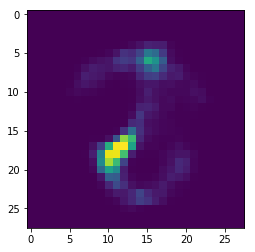

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
sample = torch.autograd.Variable(torch.randn(1, 20))
sample = model.decode(sample)
img = sample.data.view(28, 28)
plt.imshow(img)

In [8]:
testloader = torch.utils.data.DataLoader(testset, batch_size=10, num_workers=2)
n=0
for num_batch, data in enumerate(testloader):
    myInput, _ = data
    myInput = myInput.view(10, 1, 784)
    myInput = torch.autograd.Variable(myInput)
    myOutput = autoencoder(myInput)
    break
    
myInput = myInput.data.numpy()
myOutput = myOutput.data.numpy()

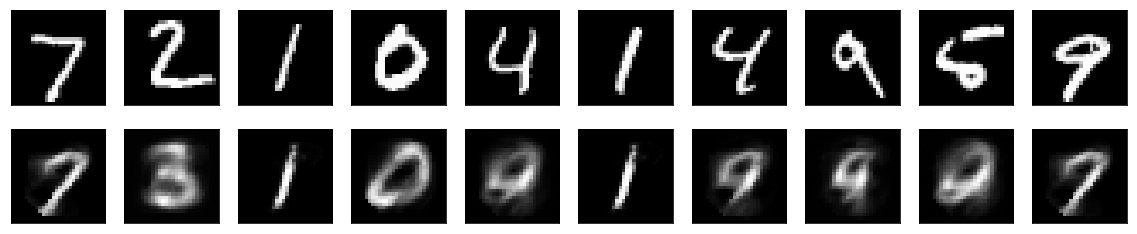

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(myInput[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(myOutput[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()